# 🧠 MURA X-Ray Classification with EfficientNet

<h1>MURA Classification</h1>

## 📦 1. Imports & Environment Setup

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import os

## 📁 2. Data Loading & Preprocessing

In [2]:
base_dir = r"D:\mura"
patient_df = pd.read_csv(r"D:\mura\MURA-v1.1\train_labeled_studies.csv", header=None, names=['patient_path', 'label'])
image_df = pd.read_csv(r"D:\mura\MURA-v1.1\train_image_paths.csv", header=None, names=['image_path'])
def extract_patient_path(image_path):
        parts = image_path.split('/')
        patient_path = '/'.join(parts[:-1]) + '/'
        return patient_path
image_df['patient_path'] = image_df['image_path'].apply(extract_patient_path)

train_df = pd.merge(image_df, patient_df, on='patient_path')
train_df = train_df[['image_path', 'label']]

train_df['image_path'] = base_dir + '\\' + train_df['image_path']
labels = train_df['label']

In [3]:
val_patient_df = pd.read_csv(r"D:\mura\MURA-v1.1\valid_labeled_studies.csv", header=None, names=['patient_path', 'label'])
val_image_df = pd.read_csv(r"D:\mura\MURA-v1.1\valid_image_paths.csv", header=None, names=['image_path'])
val_image_df['patient_path'] = val_image_df['image_path'].apply(extract_patient_path)


val_df = pd.merge(val_image_df, val_patient_df, on='patient_path')
val_df = val_df[['image_path', 'label']] 
val_df['image_path'] = base_dir + '\\' + val_df['image_path']


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_df['label'].values

class_weights = compute_class_weight('balanced', classes=np.unique(labels),y=labels)
class_weights_dict = {float(i): weight for i, weight in enumerate(class_weights)}

print(f"Class weights: {class_weights_dict}")

Class weights: {0.0: 0.8390243902439024, 1.0: 1.2374100719424461}


In [5]:
val_df['label'] =val_df['label'].astype(str)
train_df['label'] =train_df['label'].astype(str)

In [6]:
 train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
 )

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=r"D:\mura\MURA-v1.1\train",
        x_col="image_path",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        color_mode='rgb',
        class_mode="binary",
        shuffle=True
    )
val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory="D:\mura\MURA-v1.1\valid",
        x_col="image_path",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        color_mode='rgb',
        class_mode="binary",
        shuffle=False
    )

Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


## 🏗️ 3. Model Architecture

In [8]:
import efficientnet.keras as efn

In [9]:
base_model = efn.EfficientNetB0(
    input_shape = (224,224,3),
    include_top = True,
)

In [10]:
for layer in base_model.layers:  
    layer.trainable = False

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import plot_model

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="swish")(x)
x = Dense(256, activation="swish")(x)
predictions = Dense(1, activation="sigmoid")(x)

model_final = Model(inputs=base_model.input, outputs=predictions)


In [12]:
from tensorflow.keras.optimizers import RMSprop

model_final.compile(
    optimizer = RMSprop(learning_rate=0.0001),
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)

In [13]:
eff_history = model_final.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
    class_weight=class_weights_dict
)

Epoch 1/10
4601/4601 [==============================] - 557s 119ms/step - loss: 0.6762 - accuracy: 0.5765 - val_loss: 0.6558 - val_accuracy: 0.6168
Epoch 2/10
4601/4601 [==============================] - 429s 93ms/step - loss: 0.6627 - accuracy: 0.6007 - val_loss: 0.6467 - val_accuracy: 0.6287
Epoch 3/10
4601/4601 [==============================] - 314s 68ms/step - loss: 0.6599 - accuracy: 0.6077 - val_loss: 0.6469 - val_accuracy: 0.6221
Epoch 4/10
4601/4601 [==============================] - 314s 68ms/step - loss: 0.6568 - accuracy: 0.6111 - val_loss: 0.6461 - val_accuracy: 0.6331
Epoch 5/10
4601/4601 [==============================] - 313s 68ms/step - loss: 0.6569 - accuracy: 0.6123 - val_loss: 0.6435 - val_accuracy: 0.6347
Epoch 6/10
4601/4601 [==============================] - 314s 68ms/step - loss: 0.6550 - accuracy: 0.6138 - val_loss: 0.6432 - val_accuracy: 0.6362
Epoch 7/10
4601/4601 [==============================] - 315s 68ms/step - loss: 0.6546 - accuracy: 0.6152 - val_loss: 

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_final.predict(val_generator)
y_pred_classes = (y_pred > 0.31).astype("int")


y_true = val_generator.classes

print(classification_report(y_true, y_pred_classes))

400/400 [==============================] - 8s 20ms/step
              precision    recall  f1-score   support

           0       0.72      0.20      0.32      1667
           1       0.51      0.92      0.66      1530

    accuracy                           0.54      3197
   macro avg       0.62      0.56      0.49      3197
weighted avg       0.62      0.54      0.48      3197



In [17]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.3, 0.7, 0.01)
best_thresh = 0.5
best_f1 = 0

for t in thresholds:
    preds = (y_pred > t).astype("int")
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh}, F1-score: {best_f1}")


Best threshold: 0.31, F1-score: 0.6578947368421053


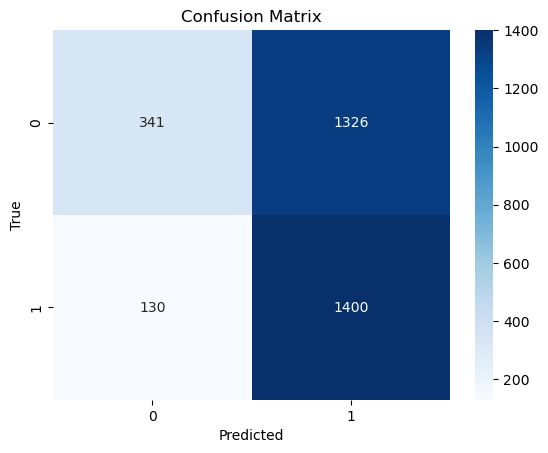

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


<hr>
<hr>
Implementing Early stopping
<hr>
<hr>

## 🏋️ 4. Model Training

In [20]:
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
model_final1 = Model(inputs=base_model.input, outputs=predictions)
model_final1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tfa.losses.SigmoidFocalCrossEntropy(gamma=2.0, alpha=0.25),
    metrics=["accuracy", AUC(), Precision(), Recall()]
)


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
]
model_final1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


Epoch 1/10
4601/4601 [==============================] - 320s 69ms/step - loss: 0.0685 - accuracy: 0.6151 - auc_1: 0.6644 - precision_1: 0.7066 - recall_1: 0.0810 - val_loss: 0.0665 - val_accuracy: 0.5599 - val_auc_1: 0.6852 - val_precision_1: 0.8596 - val_recall_1: 0.0961
Epoch 2/10
4601/4601 [==============================] - 317s 69ms/step - loss: 0.0680 - accuracy: 0.6134 - auc_1: 0.6645 - precision_1: 0.7348 - recall_1: 0.0676 - val_loss: 0.0662 - val_accuracy: 0.5580 - val_auc_1: 0.6908 - val_precision_1: 0.8545 - val_recall_1: 0.0922
Epoch 3/10
4601/4601 [==============================] - 315s 68ms/step - loss: 0.0679 - accuracy: 0.6154 - auc_1: 0.6664 - precision_1: 0.7588 - recall_1: 0.0707 - val_loss: 0.0663 - val_accuracy: 0.5574 - val_auc_1: 0.6943 - val_precision_1: 0.8402 - val_recall_1: 0.0928
Epoch 4/10
4601/4601 [==============================] - 315s 68ms/step - loss: 0.0676 - accuracy: 0.6180 - auc_1: 0.6717 - precision_1: 0.7579 - recall_1: 0.0802 - val_loss: 0.0660 

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_final1.predict(val_generator)
y_pred_classes = (y_pred > 0.34).astype("int")

y_true = val_generator.classes

print(classification_report(y_true, y_pred_classes))

400/400 [==============================] - 9s 20ms/step
              precision    recall  f1-score   support

           0       0.73      0.23      0.34      1667
           1       0.52      0.91      0.66      1530

    accuracy                           0.55      3197
   macro avg       0.63      0.57      0.50      3197
weighted avg       0.63      0.55      0.50      3197



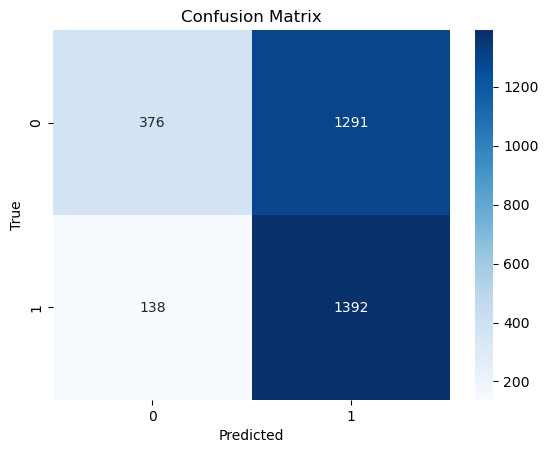

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [24]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.3, 0.7, 0.01)
best_thresh = 0.5
best_f1 = 0

for t in thresholds:
    preds = (y_pred > t).astype("int")
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh}, F1-score: {best_f1}")

Best threshold: 0.36000000000000004, F1-score: 0.6697459584295612


<hr>
<hr>
K fold
<hr>
<hr>

In [25]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

X = train_df["image_path"].values
y = train_df["label"].values
n_splits = 5 
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_no = 1
results = []
base_model = efn.EfficientNetB0(
    input_shape = (224,224,3),
    include_top = True,
)
for layer in base_model.layers:  
    layer.trainable = True

for train_index, val_index in skf.split(X, y):
    print(f"\n Fold {fold_no}")
    train_fold_df = train_df.iloc[train_index]
    val_fold_df = train_df.iloc[val_index]

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_fold_df,
        directory=r"D:\mura\MURA-v1.1\train",
        x_col="image_path",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        color_mode='rgb',
        class_mode="binary",
        shuffle=True
    )
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_fold_df,
        directory=r"D:\mura\MURA-v1.1\train", 
        x_col="image_path",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        color_mode='rgb',
        class_mode="binary",
        shuffle=False
    )

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation="swish")(x)
    x = Dense(256, activation="swish")(x)
    predictions = Dense(1, activation="sigmoid")(x)

    model_final2 = Model(inputs=base_model.input, outputs=predictions)
    
    model_final2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tfa.losses.SigmoidFocalCrossEntropy(gamma=2.0, alpha=0.25),
    metrics=["accuracy", AUC(), Precision(), Recall()]
    )
    history = model_final2.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,
        class_weight=class_weights_dict,
        callbacks=callbacks
    )

    scores = model_final2.evaluate(val_generator)
    results.append(scores)

    fold_no += 1



 Fold 1
Found 29446 validated image filenames belonging to 2 classes.
Found 7362 validated image filenames belonging to 2 classes.
Epoch 1/5
3681/3681 [==============================] - 293s 78ms/step - loss: 0.0595 - accuracy: 0.7079 - auc_2: 0.7720 - precision_2: 0.8528 - recall_2: 0.3349 - val_loss: 0.0506 - val_accuracy: 0.7469 - val_auc_2: 0.8171 - val_precision_2: 0.9270 - val_recall_2: 0.4057
Epoch 2/5
3681/3681 [==============================] - 288s 78ms/step - loss: 0.0527 - accuracy: 0.7684 - auc_2: 0.8288 - precision_2: 0.8747 - recall_2: 0.4982 - val_loss: 0.0495 - val_accuracy: 0.7582 - val_auc_2: 0.8296 - val_precision_2: 0.9135 - val_recall_2: 0.4437
Epoch 3/5
3681/3681 [==============================] - 287s 78ms/step - loss: 0.0505 - accuracy: 0.7838 - auc_2: 0.8441 - precision_2: 0.8843 - recall_2: 0.5349 - val_loss: 0.0480 - val_accuracy: 0.7728 - val_auc_2: 0.8414 - val_precision_2: 0.9064 - val_recall_2: 0.4881
Epoch 4/5
3681/3681 [==============================]

## 📊 5. Evaluation & Visualization

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

results1 = model_final1.evaluate(val_generator, verbose=0)
results2 = model_final2.evaluate(val_generator, verbose=0)

print(f"Model 1 - Loss: {results1[0]:.4f}, Accuracy: {results1[1]:.4f}")
print(f"Model 2 - Loss: {results2[0]:.4f}, Accuracy: {results2[1]:.4f}")



Model 1 - Loss: 0.0637, Accuracy: 0.6367
Model 2 - Loss: 0.0398, Accuracy: 0.8536


In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())


y_prob1 = model_final1.predict(val_generator)
y_prob2 = model_final2.predict(val_generator)


threshold = 0.5
y_pred1 = (y_prob1 > threshold).astype("int").flatten()
y_pred2 = (y_prob2 > threshold).astype("int").flatten()


print("Model 1 Classification Report:")
print(classification_report(y_true, y_pred1, target_names=class_labels))

print("\nModel 2 Classification Report:")
print(classification_report(y_true, y_pred2, target_names=class_labels))



921/921 [==============================] - 19s 21ms/step
Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.98      0.76      4387
           1       0.83      0.13      0.22      2974

    accuracy                           0.64      7361
   macro avg       0.73      0.55      0.49      7361
weighted avg       0.71      0.64      0.54      7361


Model 2 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4387
           1       0.89      0.73      0.80      2974

    accuracy                           0.85      7361
   macro avg       0.86      0.83      0.84      7361
weighted avg       0.86      0.85      0.85      7361



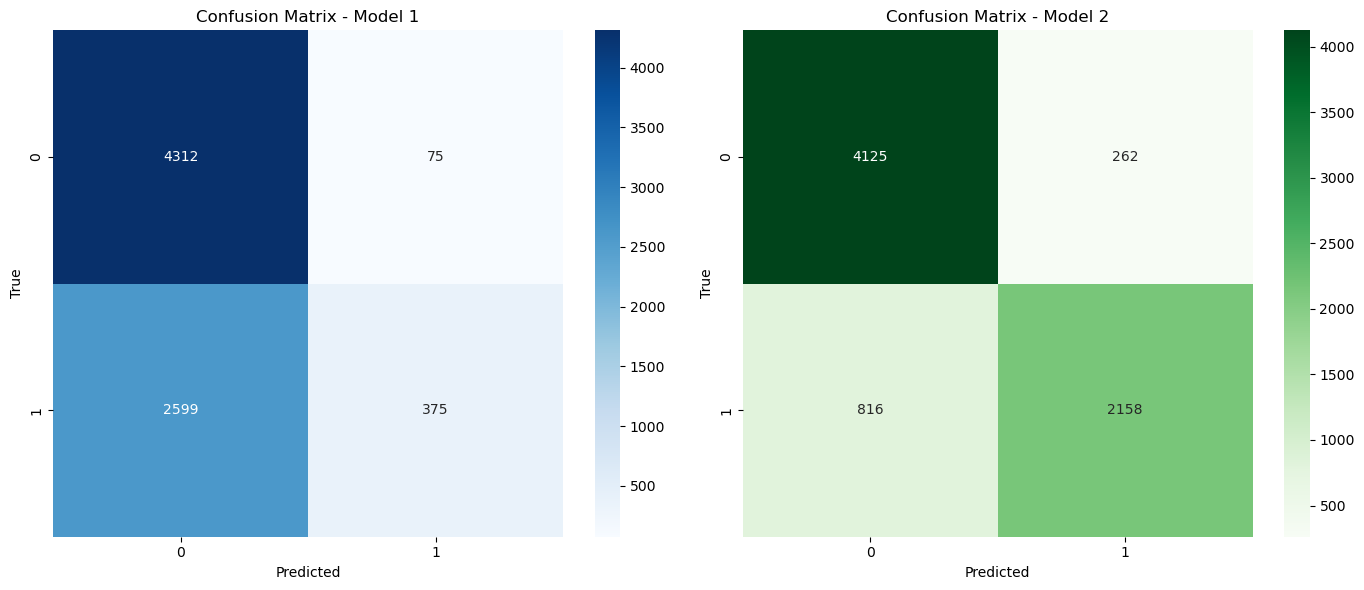

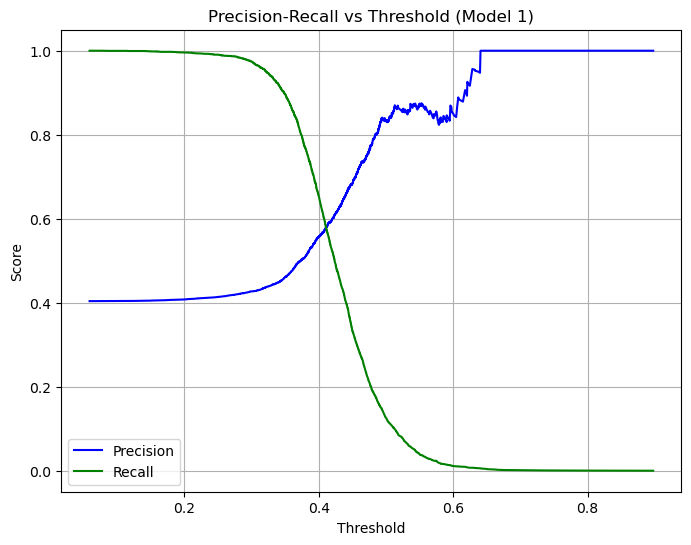

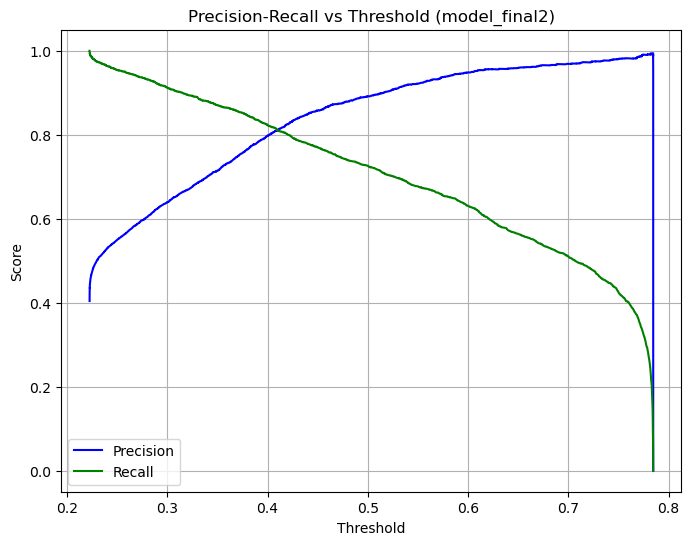

In [41]:
# Plot confusion matrices
cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm1, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=axs[0], cmap="Blues")
axs[0].set_title('Confusion Matrix - Model 1')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm2, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=axs[1], cmap="Greens")
axs[1].set_title('Confusion Matrix - Model 2')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

precision, recall, thresholds = precision_recall_curve(y_true, y_prob1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold (Model 1)')
plt.legend()
plt.grid(True)
plt.show()

precision_final2, recall_final2, thresholds_final2 = precision_recall_curve(y_true, y_prob2)

plt.figure(figsize=(8, 6))
plt.plot(thresholds_final2, precision_final2[:-1], label='Precision', color='b')
plt.plot(thresholds_final2, recall_final2[:-1], label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold (model_final2)')
plt.legend()
plt.grid(True)
plt.show()



In [42]:
from sklearn.metrics import f1_score
import numpy as np

thresholds = np.arange(0.3, 0.7, 0.01)

# Model 1
best_thresh1 = 0.5
best_f1_1 = 0
for t in thresholds:
    preds = (y_prob1 > t).astype("int")
    f1 = f1_score(y_true, preds)
    if f1 > best_f1_1:
        best_f1_1 = f1
        best_thresh1 = t

# Model 2
best_thresh2 = 0.5
best_f1_2 = 0
for t in thresholds:
    preds = (y_prob2 > t).astype("int")
    f1 = f1_score(y_true, preds)
    if f1 > best_f1_2:
        best_f1_2 = f1
        best_thresh2 = t

print(f"Model 1 - Best threshold: {best_thresh1}, F1-score: {best_f1_1:.4f}")
print(f"Model 2 - Best threshold: {best_thresh2}, F1-score: {best_f1_2:.4f}")

Model 1 - Best threshold: 0.37000000000000005, F1-score: 0.6183
Model 2 - Best threshold: 0.4200000000000001, F1-score: 0.8124


In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

y_prob1 = model_final1.predict(val_generator)
y_prob2 = model_final2.predict(val_generator)

y_pred1 = (y_prob1 > best_thresh1).astype("int").flatten()
y_pred2 = (y_prob2 > best_thresh2).astype("int").flatten()

# Print classification reports
print("Model 1 Classification Report:")
print(classification_report(y_true, y_pred1, target_names=class_labels))

print("\nModel 2 Classification Report:")
print(classification_report(y_true, y_pred2, target_names=class_labels))


921/921 [==============================] - 20s 21ms/step
Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.44      0.56      4387
           1       0.50      0.82      0.62      2974

    accuracy                           0.59      7361
   macro avg       0.64      0.63      0.59      7361
weighted avg       0.67      0.59      0.58      7361


Model 2 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4387
           1       0.82      0.80      0.81      2974

    accuracy                           0.85      7361
   macro avg       0.85      0.84      0.84      7361
weighted avg       0.85      0.85      0.85      7361



In [44]:
model_final1.save('model1.h5')
model_final2.save('model.h5')